Tutorial 8: We show in this tutorial how to use MrBeam and DoG-HiT to do polarimetry. To do polarized imaging, we first do Stokes I imaging: let us repeat the steps from tutorial 7.

In [23]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

from imagingbase.ehtim_calibration import Calibrator
from imagingbase.minimization_handler import MinimizationHandler
from imagingbase.polimaging import PolHandler
from imagingbase.ehtim_wrapper_pol import EhtimWrapperPol
from imagingbase.solvers.scipy_solver import Minimize

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

In [24]:
#-------------------------------------------------------------------------------
# Synthetic observation
#-------------------------------------------------------------------------------

# Load the image and the array
im = eh.image.load_txt(r'/homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt')
obs = eh.obsdata.load_uvfits(r'../synthetic_data/sgra_eht2017.uvfits')

Loading text image:  /homes/hmueller/eht-imaging-main/models/avery_sgra_eofn.txt
Loading uvfits:  ../synthetic_data/sgra_eht2017.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


In [25]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = im.total_flux()                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 200.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities
                                                               
#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-8                # Imager stopping criterion
gain_tol  = [0.02,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['AA', 'AP']    # baseline to measure zero-spacing flux
rescaling = 0.0035              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 25*10**9]       #cbar-lims for interactive plotting (brightness temperature)

In [26]:
#-------------------------------------------------------------------------------
# Prepare the data
#-------------------------------------------------------------------------------
cal = Calibrator(obs, zero_baseline, zbl, uv_zblcut, 0, sys_noise)
cal.prepare_data()

#-------------------------------------------------------------------------------
# Pre-calibrate the data
#-------------------------------------------------------------------------------

res    = cal.obs.res()  # The nominal array resolution: 1/(longest baseline)

# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image
gaussprior = eh.image.make_square(cal.obs, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# To avoid gradient singularities in the first step, add an additional small Gaussians
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, prior_fwhm, prior_fwhm))

cal.precalibrate_data()

obs_sc = cal.obs_sc

In [27]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.15*10**9
#add short baselines wavelets 
short_bl_wl=[20, 23.7]
#add long baseline wavelets
long_bl_wl=[]

#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, gaussprior, zbl, rescaling, data_term, cbar_lims, threshold, short_bl_wl, long_bl_wl, md=True, bessel=True, ellipticities=4) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...
Generating I image...


Round 1: Find initial guess ...
Initializing imager data products . . .
U-V flagged 139/1423 visibilities
U-V flagged 1284/1423 visibilities
Imager run 1 
Imaging . . .
time: 4.255263 s
J: 17.474381
chi2_amp : 36.45 chi2_cphase : 5.69 chi2_logcamp : 6.63 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 3.939265 s
J: 5.305237
chi2_amp : 18.65 chi2_cphase : 1.76 chi2_logcamp : 1.93 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 4.654829 s
J: 2.776101
chi2_amp : 13.13 chi2_cphase : 1.05 chi2_logcamp : 1.28 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 4.148250 s
J: 1.671269
chi2_amp : 10.80 chi2_cphase : 0.78 chi2_logcamp : 0.92 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 4.571446 s
J: 0.958822
chi2_amp : 9.19 chi2_cphase : 0.61 chi2_logcamp : 0.70 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
Imaging . . .
time: 4.355719 s
J: 0.487169
chi2_amp : 8

2023-09-19 17:27:01,501 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:01,503 INFO Display              :: Penalty--> 65.6605044474435
2023-09-19 17:27:01,881 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:01,882 INFO Display              :: Penalty--> 64.89031560601433
2023-09-19 17:27:02,251 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:02,253 INFO Display              :: Penalty--> 64.21695047222329
2023-09-19 17:27:02,641 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:02,642 INFO Display              :: Penalty--> 63.87631164560371
2023-09-19 17:27:03,012 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:03,013 INFO Display              :: Penalty--> 63.61456763609792
2023-09-19 17:27:03,384 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:03,385 INFO Display              :: Penalty--> 63.353232037394214
2023-09-19 17:27:03,754 INFO CountIterations      :: iteration = 7 / 25
2023

453.43460918091614
Data Fidelity:  11.943437026123876


2023-09-19 17:27:11,438 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:11,440 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:11,833 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:11,834 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:12,203 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:12,204 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:12,574 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:12,575 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:12,969 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:12,970 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:13,357 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:13,359 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:13,747 INFO CountIterations      :: iteration = 7 / 25
2023

705.3200679255058
Data Fidelity:  10.443557931037162


2023-09-19 17:27:21,142 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:21,143 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:21,513 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:21,514 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:21,888 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:21,889 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:22,260 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:22,262 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:22,631 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:22,633 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:23,001 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:23,003 INFO Display              :: Penalty--> 61.17560266597946
2023-09-19 17:27:23,373 INFO CountIterations      :: iteration = 7 / 25
2023

706.7048886936807
Data Fidelity:  9.44157630948775


2023-09-19 17:27:30,768 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:30,769 INFO Display              :: Penalty--> 61.16666764872218
2023-09-19 17:27:31,152 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:31,153 INFO Display              :: Penalty--> 61.03943218438043
2023-09-19 17:27:31,523 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:31,524 INFO Display              :: Penalty--> 61.03943218438043
2023-09-19 17:27:31,901 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:31,902 INFO Display              :: Penalty--> 61.03943218438043
2023-09-19 17:27:32,292 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:32,293 INFO Display              :: Penalty--> 61.03943218438043
2023-09-19 17:27:32,675 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:32,677 INFO Display              :: Penalty--> 61.03943218438043
2023-09-19 17:27:33,049 INFO CountIterations      :: iteration = 7 / 25
2023

707.5385035442788
Data Fidelity:  8.671727386485799


2023-09-19 17:27:40,666 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:40,667 INFO Display              :: Penalty--> 61.0036921153513
2023-09-19 17:27:41,038 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:41,039 INFO Display              :: Penalty--> 61.0036921153513
2023-09-19 17:27:41,439 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:41,441 INFO Display              :: Penalty--> 60.98582208083674
2023-09-19 17:27:41,831 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:41,832 INFO Display              :: Penalty--> 60.976887063579454
2023-09-19 17:27:42,201 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:42,203 INFO Display              :: Penalty--> 60.976887063579454
2023-09-19 17:27:42,572 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:42,574 INFO Display              :: Penalty--> 60.976887063579454
2023-09-19 17:27:42,943 INFO CountIterations      :: iteration = 7 / 25
202

708.4620366855946
Data Fidelity:  8.0425677496076


2023-09-19 17:27:50,251 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:50,252 INFO Display              :: Penalty--> 60.61369160909976
2023-09-19 17:27:50,621 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:27:50,622 INFO Display              :: Penalty--> 60.61369160909976
2023-09-19 17:27:50,992 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:27:50,993 INFO Display              :: Penalty--> 60.604756591842474
2023-09-19 17:27:51,362 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:27:51,364 INFO Display              :: Penalty--> 60.586886557327915
2023-09-19 17:27:51,732 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:27:51,734 INFO Display              :: Penalty--> 60.586886557327915
2023-09-19 17:27:52,103 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:27:52,104 INFO Display              :: Penalty--> 60.57795154007063
2023-09-19 17:27:52,473 INFO CountIterations      :: iteration = 7 / 25
2

708.6258723239966
Data Fidelity:  7.610662703705215


2023-09-19 17:27:59,800 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:27:59,801 INFO Display              :: Penalty--> 60.502906068192324
2023-09-19 17:28:00,169 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:28:00,171 INFO Display              :: Penalty--> 60.502906068192324
2023-09-19 17:28:00,541 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:28:00,542 INFO Display              :: Penalty--> 60.502906068192324
2023-09-19 17:28:00,911 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:28:00,912 INFO Display              :: Penalty--> 60.493971050935045
2023-09-19 17:28:01,285 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:28:01,287 INFO Display              :: Penalty--> 60.493971050935045
2023-09-19 17:28:01,655 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:28:01,657 INFO Display              :: Penalty--> 60.48503603367776
2023-09-19 17:28:02,026 INFO CountIterations      :: iteration = 7 / 25

708.8507159543573
Data Fidelity:  7.234396789761508


2023-09-19 17:28:09,331 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:28:09,333 INFO Display              :: Penalty--> 60.27437677660285
2023-09-19 17:28:09,704 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:28:09,706 INFO Display              :: Penalty--> 60.27437677660285
2023-09-19 17:28:10,078 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:28:10,080 INFO Display              :: Penalty--> 60.26544175934557
2023-09-19 17:28:10,449 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:28:10,451 INFO Display              :: Penalty--> 60.24409728600662
2023-09-19 17:28:10,820 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:28:10,822 INFO Display              :: Penalty--> 60.235162268749335
2023-09-19 17:28:11,191 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:28:11,193 INFO Display              :: Penalty--> 60.235162268749335
2023-09-19 17:28:11,562 INFO CountIterations      :: iteration = 7 / 25
20

709.3730147522439
Data Fidelity:  6.924114520648709


2023-09-19 17:28:19,080 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:28:19,082 INFO Display              :: Penalty--> 60.057716264185565
2023-09-19 17:28:19,473 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:28:19,475 INFO Display              :: Penalty--> 60.057716264185565
2023-09-19 17:28:19,848 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:28:19,850 INFO Display              :: Penalty--> 60.045772609510635
2023-09-19 17:28:20,220 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:28:20,221 INFO Display              :: Penalty--> 60.036837592253356
2023-09-19 17:28:20,590 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:28:20,592 INFO Display              :: Penalty--> 60.036837592253356
2023-09-19 17:28:20,959 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:28:20,961 INFO Display              :: Penalty--> 60.036837592253356
2023-09-19 17:28:21,330 INFO CountIterations      :: iteration = 7 / 2

709.7706611983665
Data Fidelity:  6.653311505033455


2023-09-19 17:28:28,749 INFO CountIterations      :: iteration = 1 / 25
2023-09-19 17:28:28,751 INFO Display              :: Penalty--> 59.82064288124282
2023-09-19 17:28:29,153 INFO CountIterations      :: iteration = 2 / 25
2023-09-19 17:28:29,154 INFO Display              :: Penalty--> 59.82064288124282
2023-09-19 17:28:29,548 INFO CountIterations      :: iteration = 3 / 25
2023-09-19 17:28:29,550 INFO Display              :: Penalty--> 59.82064288124282
2023-09-19 17:28:29,942 INFO CountIterations      :: iteration = 4 / 25
2023-09-19 17:28:29,944 INFO Display              :: Penalty--> 59.810203545276714
2023-09-19 17:28:30,329 INFO CountIterations      :: iteration = 5 / 25
2023-09-19 17:28:30,330 INFO Display              :: Penalty--> 59.798259890601784
2023-09-19 17:28:30,708 INFO CountIterations      :: iteration = 6 / 25
2023-09-19 17:28:30,710 INFO Display              :: Penalty--> 59.780389856087226
2023-09-19 17:28:31,105 INFO CountIterations      :: iteration = 7 / 25
2

709.6762499146886
Data Fidelity:  6.3891856602509485


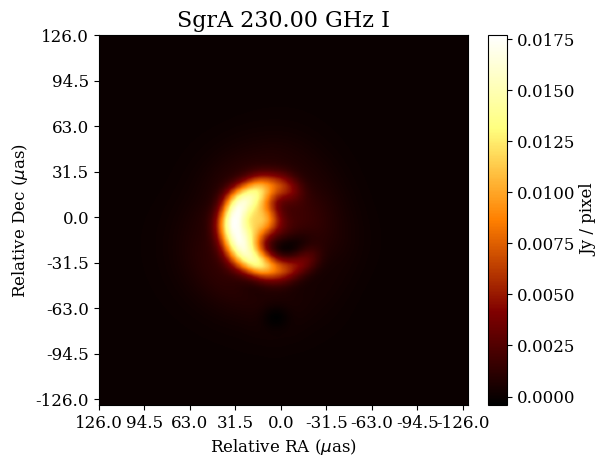

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 109/110 : [----------------------------- ]99%
self_cal time: 14.237369 s


In [28]:
#------------------------------------------------------------------------------
# Run DoG-HiT
#------------------------------------------------------------------------------
alpha=0.5 #wavelet sparsity constraint
tau=1 #stepsize in minimization
img2, wtfcts2, table1, obs_sc = handler.doghit(gaussprior, data_term, cycles=5, last_epochs=False, solution_interval=0, alpha=alpha, tau=tau, maxiter=10, display=False)
img2.display()

obs_sc = eh.selfcal(obs_sc, img2, method='phase', ttype=ttype)
handler.updateobs(obs_sc.copy())

Now we have a Stokes I representation of the image. Recall from tutorial 5 and tutorial 6 that DoG-HiT computes the multiresolution support as a byproduct. We used this information before to refine the Stokes I imaging. Now we use the same prior information (only changing coefficients in the multiresolution support) to do polarized imaging for Q and U.

Similarly to Stokes I imaging, we first define a wrapper object for the polarized quantities. Then we define the minimization handler for polarized quantities. Note that the multiscale dictionary (handler.op), the multiresolution support (handler.mask) are already stored in the handler object. So we just copy over these properties.

In the moment only pol_trans=False and pol_solve=(1,1,1) are supported right now.

In [29]:
wrapper = EhtimWrapperPol(obs_sc, img2.regrid_image(fov, npix+1), img2.regrid_image(fov, npix+1), zbl, d='pvis', clipfloor=-100, pol_solve=(1,1,1), pol_trans=False)
pol = PolHandler(wrapper, handler.mask, handler.op, wtfcts2*rescaling)

Generating I image...
No polarimetric image in the initial image!


Now we are ready to do Stokes Q and U imaging with a gradient descent algorithm. The initial guess and the objective functional and Hilbert Space Setting are allocated by the PolHandler under pol.final_init, pol.final_func and pol.final_setting.

2023-09-19 17:30:14,130 INFO CountIterations      :: iteration = 1 / 1000
2023-09-19 17:30:14,245 INFO Display              :: Data Fidelity--> 2.274422229312053
2023-09-19 17:30:14,656 INFO CountIterations      :: iteration = 2 / 1000
2023-09-19 17:30:14,770 INFO Display              :: Data Fidelity--> 2.2074609199552944
2023-09-19 17:30:15,186 INFO CountIterations      :: iteration = 3 / 1000
2023-09-19 17:30:15,296 INFO Display              :: Data Fidelity--> 2.1441177122300314
2023-09-19 17:30:15,708 INFO CountIterations      :: iteration = 4 / 1000
2023-09-19 17:30:15,819 INFO Display              :: Data Fidelity--> 2.0841649766898245
2023-09-19 17:30:16,232 INFO CountIterations      :: iteration = 5 / 1000
2023-09-19 17:30:16,347 INFO Display              :: Data Fidelity--> 2.0273902631782654
2023-09-19 17:30:16,762 INFO CountIterations      :: iteration = 6 / 1000
2023-09-19 17:30:16,872 INFO Display              :: Data Fidelity--> 1.9735952604663187
2023-09-19 17:30:17,284

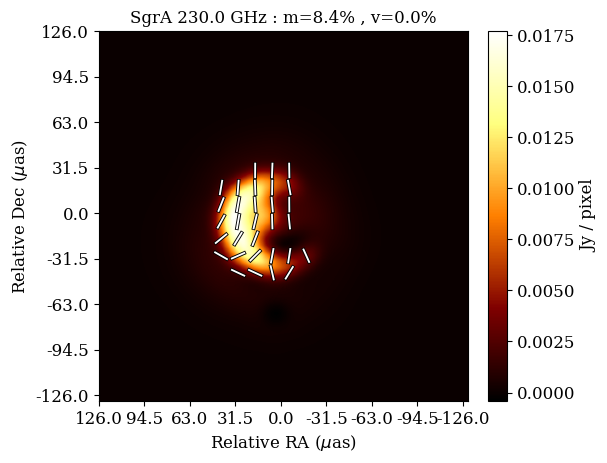

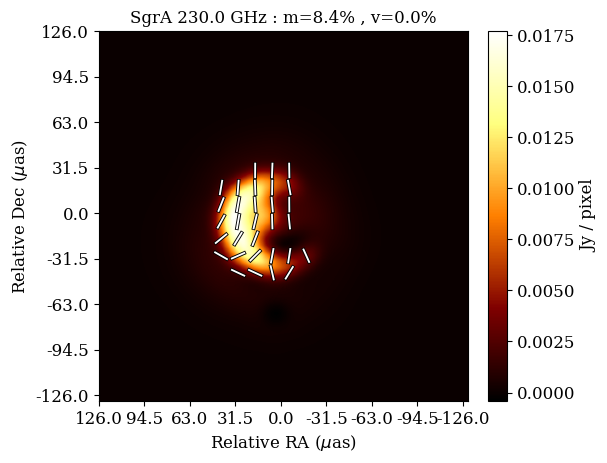

In [30]:
options = {'maxiter':100}

solver = Minimize(pol.final_func, pol.final_init.flatten(), method='L-BFGS-B', options=options)
solver.hess = None

reco = solver.run()
reco2 = pol.final_op(reco)
out = wrapper.formatoutput(reco2)

pol.find_pol_init(out.blur_circ(0,res))

reco = handler.grad_desc(pol.final_init.flatten().copy(), 10**(-6), pol.final_func, pol.final_setting, maxit=1000)
reco2 = pol.final_op(reco)

out = wrapper.formatoutput(reco2)

out.display(plotp=True)

Additionally to doing polarimetry, MrBeam also contains an operator that maps the polarized tuple (I, Q, U) onto the polarized closure trace ([Broderick and Pesce, 2020, ApJ, 904, 2, 126]). These traces are independent of calibration effects, in particular D-terms, but they also contain degeneracies (e.g. rottaion invariance in Poincare sphere). 

The ClosureTracePol class is a fully regpy operator. Hence, there is not only an implementation of the evaluation, but also of the derivative and the adjoint of the derivative. Thus, it is possible to use the closure traces as a calibration independent data fidelity term additionally to the option of using polarized visibilities. However, the minimization is very unstable. 

In [31]:
from imagingbase.operators.pol_trace import ClosureTracePol

clpol = ClosureTracePol(wrapper)
xtuple = wrapper.xtuple

print(clpol(xtuple))

[ 1.75873827e+00-8.07104486e-03j  2.84195663e+00+1.48909156e-02j
  3.06176479e-01+8.52141806e-02j  9.78932776e+01+7.61143914e+01j
 -1.99754010e+00+1.20116927e-01j  1.81425653e+00+1.81867753e-02j
  2.73058527e+00-2.52113574e-02j  3.11750069e-01+7.44844315e-02j
  9.56031362e+01+6.65568181e+01j -1.96813110e+00+3.61809275e-01j
  1.86022067e+00+4.16851272e-02j  2.63800987e+00-5.66691060e-02j
  3.15734830e-01+6.50537552e-02j  9.35227525e+01+5.87727994e+01j
 -1.91716489e+00+5.73448426e-01j  1.89645411e+00+6.32367411e-02j
  2.56212561e+00-8.27317079e-02j  3.18249274e-01+5.73191983e-02j
  9.17123460e+01+5.25512496e+01j -1.85310881e+00+7.55204645e-01j
  1.92331208e+00+8.37731419e-02j  2.50027834e+00-1.05969644e-01j
  3.19428389e-01+5.15230765e-02j  9.01911647e+01+4.76686648e+01j
 -1.78213568e+00+9.10155665e-01j  1.94061380e+00+1.03589394e-01j
  2.45165955e+00-1.27728345e-01j  3.19340174e-01+4.79865616e-02j
  8.90010474e+01+4.40764442e+01j -1.71088468e+00+1.03796420e+00j
  1.94888674e+00+1.231635

In [29]:
widths

array([ 5.99898717,  6.24240044,  6.51896717,  6.7558267 ,  7.17272775,
       20.94378003, 32.5       ])

In [22]:
len(obs_sc.data)

1423